## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import BatchNormalization
from keras import optimizers
from keras.regularizers import l1, l2, l1_l2
from collections import defaultdict
import matplotlib.pyplot as plt

#%matplotlib inline

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=False):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_data_shape, dropout_rate, l2_rate):
    model = Sequential()
    
    #卷積層1與池化層1
    model.add(Conv2D(filters=512, kernel_size=(3, 3), input_shape=input_data_shape, padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層2與池化層2
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層3與池化層3
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #卷積層4與池化層4
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same'))
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #建立神經網路(平坦層、隱藏層、輸出層)
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(l2_rate)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(10, activation='softmax', kernel_regularizer=l2(l2_rate)))

    return model

In [6]:
## 超參數設定
# OPTIMIZER = ["sgd", "rmsprop", "adam", "adagrad"]
OPTIMIZER = ["adam"]
LEARNING_RATE = 1e-4
L2_EXP = 1e-4
DROPOUT = [0.5, 0.3, 0.1]
EPOCHS = 100
BATCH_SIZE = 64
MOMENTUM = 0.95

In [7]:
tra_loss = defaultdict(list)
val_loss = defaultdict(list)
tra_accu = defaultdict(list)
val_accu = defaultdict(list)

for i, drop_rate in enumerate(DROPOUT):
    for j, optr in enumerate(OPTIMIZER):
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Optimizer=%s, ls=%.6f, dr=%.2f, bs=%d" % (optr, LEARNING_RATE, drop_rate, BATCH_SIZE))
        
        # create model
        model = build_mlp(x_train.shape[1:], drop_rate, L2_EXP)
        
        # optimizer
        if optr == "sgd":
            optimizer = optimizers.SGD(lr=LEARNING_RATE, decay=1e-6, momentum=MOMENTUM, nesterov=True)

        if optr == "rmsprop":
            optimizer = optimizers.RMSprop(lr=LEARNING_RATE, rho=0.9, epsilon=None, decay=0.0)

        if optr == "adam":
            optimizer = optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

        if optr == "adagrad":
            optimizer = optimizers.Adagrad(lr=LEARNING_RATE, epsilon=None, decay=0.0)
    
        # compile model and training
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
        model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), shuffle=True)

        # Collect results
        exp_tag = "%s:%s" % (("exp_"+str(i)), str(optr))
        tra_loss[exp_tag].append(model.history.history["loss"])
        val_loss[exp_tag].append(model.history.history["val_loss"])
        
        tra_accu[exp_tag].append(model.history.history["acc"])
        val_accu[exp_tag].append(model.history.history["val_acc"])


Experiment with Optimizer=adam, ls=0.000100, dr=0.50, bs=64
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 122s 2ms/step - loss: 2.3025 - acc: 0.2278 - val_loss: 2.5904 - val_acc: 0.1993
Epoch 2/100
50000/50000 [==============================] - 119s 2ms/step - loss: 1.8011 - acc: 0.3647 - val_loss: 2.4064 - val_acc: 0.2709
Epoch 3/100
50000/50000 [==============================] - 119s 2ms/step - loss: 1.6210 - acc: 0.4391 - val_loss: 2.4298 - val_acc: 0.2961
Epoch 4/100
50000/50000 [==============================] - 119s 2ms/step - loss: 1.4953 - acc: 0.4895 - val_loss: 2.3793 - val_acc: 0.3256
Epoch 5/100
50000/50000 [==============================] - 119s 2ms/step - loss: 1.3845 - acc: 0.5351 - val_loss: 2.2174 - val_acc: 0.3706
Epoch 6/100
50000/50000 [==============================] - 119s 2ms/step - loss: 1.2976 - acc: 0.5709 - val_loss: 2.6585 - val_acc: 0.3136
Epoch 7/100
50000/50000 [==============================]

Epoch 59/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.3787 - acc: 0.8845 - val_loss: 1.1439 - val_acc: 0.7069
Epoch 60/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.3800 - acc: 0.8829 - val_loss: 1.4805 - val_acc: 0.6554
Epoch 61/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.3747 - acc: 0.8863 - val_loss: 1.3552 - val_acc: 0.6550
Epoch 62/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.3701 - acc: 0.8871 - val_loss: 1.0088 - val_acc: 0.7246
Epoch 63/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.3644 - acc: 0.8870 - val_loss: 1.2305 - val_acc: 0.6889
Epoch 64/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.3611 - acc: 0.8895 - val_loss: 1.7701 - val_acc: 0.6174
Epoch 65/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.3548 - acc: 0.8912 - val_loss: 1.3325 - val_acc: 0.6872
Epoch 66/100
50000/5

Epoch 17/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.5637 - acc: 0.8314 - val_loss: 0.9170 - val_acc: 0.7287
Epoch 18/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.5432 - acc: 0.8389 - val_loss: 1.2859 - val_acc: 0.6665
Epoch 19/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.5231 - acc: 0.8443 - val_loss: 0.8875 - val_acc: 0.7437
Epoch 20/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.5041 - acc: 0.8499 - val_loss: 0.9338 - val_acc: 0.7254
Epoch 21/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.4868 - acc: 0.8565 - val_loss: 0.8086 - val_acc: 0.7643
Epoch 22/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.4643 - acc: 0.8651 - val_loss: 0.9750 - val_acc: 0.7173
Epoch 23/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.4553 - acc: 0.8684 - val_loss: 0.9054 - val_acc: 0.7356
Epoch 24/100
50000/5

50000/50000 [==============================] - 118s 2ms/step - loss: 0.1549 - acc: 0.9609 - val_loss: 0.9122 - val_acc: 0.7984
Epoch 76/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.1546 - acc: 0.9613 - val_loss: 0.9055 - val_acc: 0.8025
Epoch 77/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.1507 - acc: 0.9619 - val_loss: 0.9727 - val_acc: 0.7830
Epoch 78/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.1475 - acc: 0.9632 - val_loss: 0.9690 - val_acc: 0.7809
Epoch 79/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.1471 - acc: 0.9622 - val_loss: 0.8882 - val_acc: 0.8056
Epoch 80/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.1435 - acc: 0.9647 - val_loss: 0.8787 - val_acc: 0.7992
Epoch 81/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.1409 - acc: 0.9651 - val_loss: 1.2227 - val_acc: 0.7465
Epoch 82/100
50000/50000 [=======

Epoch 33/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.1556 - acc: 0.9715 - val_loss: 0.9611 - val_acc: 0.8023
Epoch 34/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.1541 - acc: 0.9707 - val_loss: 1.0077 - val_acc: 0.7977
Epoch 35/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.1478 - acc: 0.9740 - val_loss: 1.0993 - val_acc: 0.7724
Epoch 36/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.1486 - acc: 0.9734 - val_loss: 1.0105 - val_acc: 0.7982
Epoch 37/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.1401 - acc: 0.9753 - val_loss: 1.1350 - val_acc: 0.7832
Epoch 38/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.1368 - acc: 0.9766 - val_loss: 1.0916 - val_acc: 0.7853
Epoch 39/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.1344 - acc: 0.9776 - val_loss: 1.1104 - val_acc: 0.7811
Epoch 40/100
50000/5

50000/50000 [==============================] - 118s 2ms/step - loss: 0.0666 - acc: 0.9902 - val_loss: 1.0419 - val_acc: 0.8094
Epoch 92/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.0627 - acc: 0.9906 - val_loss: 1.4411 - val_acc: 0.7657
Epoch 93/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.0636 - acc: 0.9906 - val_loss: 1.0802 - val_acc: 0.8091
Epoch 94/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.0643 - acc: 0.9900 - val_loss: 1.1333 - val_acc: 0.8016
Epoch 95/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.0603 - acc: 0.9911 - val_loss: 1.1431 - val_acc: 0.7975
Epoch 96/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.0620 - acc: 0.9906 - val_loss: 1.0424 - val_acc: 0.8085
Epoch 97/100
50000/50000 [==============================] - 118s 2ms/step - loss: 0.0616 - acc: 0.9908 - val_loss: 1.2145 - val_acc: 0.7803
Epoch 98/100
50000/50000 [=======

## Plot loss history

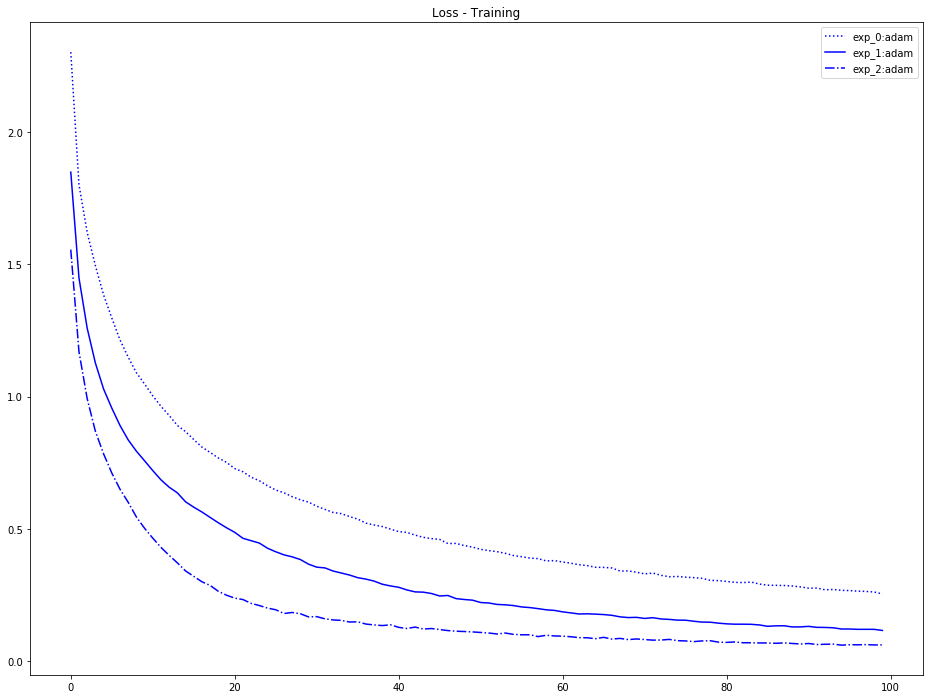

In [8]:
plt.figure(figsize=(16, 12))

# plt.plot(range(len(tra_loss["exp_0:sgd"][0])), tra_loss["exp_0:sgd"][0], ':',  label="exp_0:sgd", color="r")
# plt.plot(range(len(tra_loss["exp_1:sgd"][0])), tra_loss["exp_1:sgd"][0], '-',  label="exp_1:sgd", color="r")
# plt.plot(range(len(tra_loss["exp_2:sgd"][0])), tra_loss["exp_2:sgd"][0], '-.', label="exp_2:sgd", color="r")
# plt.plot(range(len(tra_loss["exp_3:sgd"][0])), tra_loss["exp_3:sgd"][0], '--', label="exp_3:sgd", color="r")
# plt.plot(range(len(tra_loss["exp_4:sgd"][0])), tra_loss["exp_4:sgd"][0], '.',  label="exp_4:sgd", color="r")

# plt.plot(range(len(tra_loss["exp_0:rmsprop"][0])), tra_loss["exp_0:rmsprop"][0], ':',  label="exp_0:rmsprop", color="g")
# plt.plot(range(len(tra_loss["exp_1:rmsprop"][0])), tra_loss["exp_1:rmsprop"][0], '-',  label="exp_1:rmsprop", color="g")
# plt.plot(range(len(tra_loss["exp_2:rmsprop"][0])), tra_loss["exp_2:rmsprop"][0], '-.', label="exp_2:rmsprop", color="g")
# plt.plot(range(len(tra_loss["exp_3:rmsprop"][0])), tra_loss["exp_3:rmsprop"][0], '--', label="exp_3:rmsprop", color="g")
# plt.plot(range(len(tra_loss["exp_4:rmsprop"][0])), tra_loss["exp_4:rmsprop"][0], '.',  label="exp_4:rmsprop", color="g")

plt.plot(range(len(tra_loss["exp_0:adam"][0])), tra_loss["exp_0:adam"][0], ':',  label="exp_0:adam", color="b")
plt.plot(range(len(tra_loss["exp_1:adam"][0])), tra_loss["exp_1:adam"][0], '-',  label="exp_1:adam", color="b")
plt.plot(range(len(tra_loss["exp_2:adam"][0])), tra_loss["exp_2:adam"][0], '-.', label="exp_2:adam", color="b")
# plt.plot(range(len(tra_loss["exp_3:adam"][0])), tra_loss["exp_3:adam"][0], '--', label="exp_3:adam", color="b")
# plt.plot(range(len(tra_loss["exp_4:adam"][0])), tra_loss["exp_4:adam"][0], '.',  label="exp_4:adam", color="b")

# plt.plot(range(len(tra_loss["exp_0:adagrad"][0])), tra_loss["exp_0:adagrad"][0], ':',  label="exp_0:adagrad", color="y")
# plt.plot(range(len(tra_loss["exp_1:adagrad"][0])), tra_loss["exp_1:adagrad"][0], '-',  label="exp_1:adagrad", color="y")
# plt.plot(range(len(tra_loss["exp_2:adagrad"][0])), tra_loss["exp_2:adagrad"][0], '-.', label="exp_2:adagrad", color="y")
# plt.plot(range(len(tra_loss["exp_3:adagrad"][0])), tra_loss["exp_3:adagrad"][0], '--', label="exp_3:adagrad", color="y")
# plt.plot(range(len(tra_loss["exp_4:adagrad"][0])), tra_loss["exp_4:adagrad"][0], '.',  label="exp_4:adagrad", color="y")

plt.title("Loss - Training")
plt.legend(loc="upper right")
plt.show()

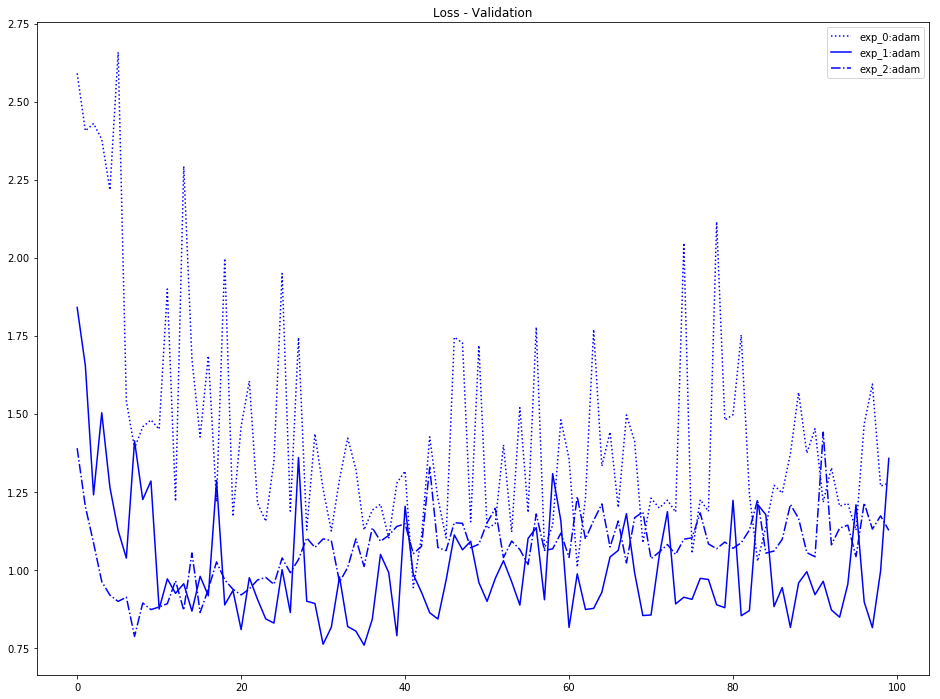

In [9]:
plt.figure(figsize=(16, 12))

# plt.plot(range(len(val_loss["exp_0:sgd"][0])), val_loss["exp_0:sgd"][0], ':',  label="exp_0:sgd", color="r")
# plt.plot(range(len(val_loss["exp_1:sgd"][0])), val_loss["exp_1:sgd"][0], '-',  label="exp_1:sgd", color="r")
# plt.plot(range(len(val_loss["exp_2:sgd"][0])), val_loss["exp_2:sgd"][0], '-.', label="exp_2:sgd", color="r")
# plt.plot(range(len(val_loss["exp_3:sgd"][0])), val_loss["exp_3:sgd"][0], '--', label="exp_3:sgd", color="r")
# plt.plot(range(len(val_loss["exp_4:sgd"][0])), val_loss["exp_4:sgd"][0], '.',  label="exp_4:sgd", color="r")

# plt.plot(range(len(val_loss["exp_0:rmsprop"][0])), val_loss["exp_0:rmsprop"][0], ':',  label="exp_0:rmsprop", color="g")
# plt.plot(range(len(val_loss["exp_1:rmsprop"][0])), val_loss["exp_1:rmsprop"][0], '-',  label="exp_1:rmsprop", color="g")
# plt.plot(range(len(val_loss["exp_2:rmsprop"][0])), val_loss["exp_2:rmsprop"][0], '-.', label="exp_2:rmsprop", color="g")
# plt.plot(range(len(val_loss["exp_3:rmsprop"][0])), val_loss["exp_3:rmsprop"][0], '--', label="exp_3:rmsprop", color="g")
# plt.plot(range(len(val_loss["exp_4:rmsprop"][0])), val_loss["exp_4:rmsprop"][0], '.',  label="exp_4:rmsprop", color="g")

plt.plot(range(len(val_loss["exp_0:adam"][0])), val_loss["exp_0:adam"][0], ':',  label="exp_0:adam", color="b")
plt.plot(range(len(val_loss["exp_1:adam"][0])), val_loss["exp_1:adam"][0], '-',  label="exp_1:adam", color="b")
plt.plot(range(len(val_loss["exp_2:adam"][0])), val_loss["exp_2:adam"][0], '-.', label="exp_2:adam", color="b")
# plt.plot(range(len(val_loss["exp_3:adam"][0])), val_loss["exp_3:adam"][0], '--', label="exp_3:adam", color="b")
# plt.plot(range(len(val_loss["exp_4:adam"][0])), val_loss["exp_4:adam"][0], '.',  label="exp_4:adam", color="b")

# plt.plot(range(len(val_loss["exp_0:adagrad"][0])), val_loss["exp_0:adagrad"][0], ':',  label="exp_0:adagrad", color="y")
# plt.plot(range(len(val_loss["exp_1:adagrad"][0])), val_loss["exp_1:adagrad"][0], '-',  label="exp_1:adagrad", color="y")
# plt.plot(range(len(val_loss["exp_2:adagrad"][0])), val_loss["exp_2:adagrad"][0], '-.', label="exp_2:adagrad", color="y")
# plt.plot(range(len(val_loss["exp_3:adagrad"][0])), val_loss["exp_3:adagrad"][0], '--', label="exp_3:adagrad", color="y")
# plt.plot(range(len(val_loss["exp_4:adagrad"][0])), val_loss["exp_4:adagrad"][0], '.',  label="exp_4:adagrad", color="y")

plt.title("Loss - Validation")
plt.legend(loc="upper right")
plt.show()

### Optimizer=Adam, batch_size=64, dropout=0.1 有較低的loss

## Plot accu history

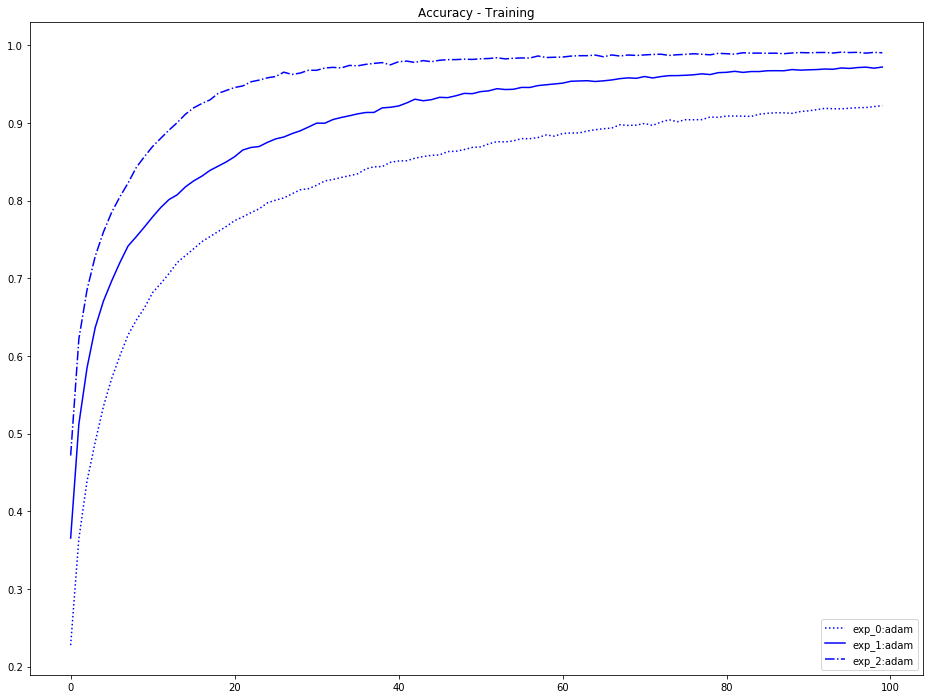

In [10]:
plt.figure(figsize=(16, 12))

# plt.plot(range(len(tra_accu["exp_0:sgd"][0])), tra_accu["exp_0:sgd"][0], ':',  label="exp_0:sgd", color="r")
# plt.plot(range(len(tra_accu["exp_1:sgd"][0])), tra_accu["exp_1:sgd"][0], '-',  label="exp_1:sgd", color="r")
# plt.plot(range(len(tra_accu["exp_2:sgd"][0])), tra_accu["exp_2:sgd"][0], '-.', label="exp_2:sgd", color="r")
# plt.plot(range(len(tra_accu["exp_3:sgd"][0])), tra_accu["exp_3:sgd"][0], '--', label="exp_3:sgd", color="r")
# plt.plot(range(len(tra_accu["exp_4:sgd"][0])), tra_accu["exp_4:sgd"][0], '.',  label="exp_4:sgd", color="r")

# plt.plot(range(len(tra_accu["exp_0:rmsprop"][0])), tra_accu["exp_0:rmsprop"][0], ':',  label="exp_0:rmsprop", color="g")
# plt.plot(range(len(tra_accu["exp_1:rmsprop"][0])), tra_accu["exp_1:rmsprop"][0], '-',  label="exp_1:rmsprop", color="g")
# plt.plot(range(len(tra_accu["exp_2:rmsprop"][0])), tra_accu["exp_2:rmsprop"][0], '-.', label="exp_2:rmsprop", color="g")
# plt.plot(range(len(tra_accu["exp_3:rmsprop"][0])), tra_accu["exp_3:rmsprop"][0], '--', label="exp_3:rmsprop", color="g")
# plt.plot(range(len(tra_accu["exp_4:rmsprop"][0])), tra_accu["exp_4:rmsprop"][0], '.',  label="exp_4:rmsprop", color="g")

plt.plot(range(len(tra_accu["exp_0:adam"][0])), tra_accu["exp_0:adam"][0], ':',  label="exp_0:adam", color="b")
plt.plot(range(len(tra_accu["exp_1:adam"][0])), tra_accu["exp_1:adam"][0], '-',  label="exp_1:adam", color="b")
plt.plot(range(len(tra_accu["exp_2:adam"][0])), tra_accu["exp_2:adam"][0], '-.', label="exp_2:adam", color="b")
# plt.plot(range(len(tra_accu["exp_3:adam"][0])), tra_accu["exp_3:adam"][0], '--', label="exp_3:adam", color="b")
# plt.plot(range(len(tra_accu["exp_4:adam"][0])), tra_accu["exp_4:adam"][0], '.',  label="exp_4:adam", color="b")

# plt.plot(range(len(tra_accu["exp_0:adagrad"][0])), tra_accu["exp_0:adagrad"][0], ':',  label="exp_0:adagrad", color="y")
# plt.plot(range(len(tra_accu["exp_1:adagrad"][0])), tra_accu["exp_1:adagrad"][0], '-',  label="exp_1:adagrad", color="y")
# plt.plot(range(len(tra_accu["exp_2:adagrad"][0])), tra_accu["exp_2:adagrad"][0], '-.', label="exp_2:adagrad", color="y")
# plt.plot(range(len(tra_accu["exp_3:adagrad"][0])), tra_accu["exp_3:adagrad"][0], '--', label="exp_3:adagrad", color="y")
# plt.plot(range(len(tra_accu["exp_4:adagrad"][0])), tra_accu["exp_4:adagrad"][0], '.',  label="exp_4:adagrad", color="y")

plt.title("Accuracy - Training")
plt.legend(loc="lower right")
plt.show()

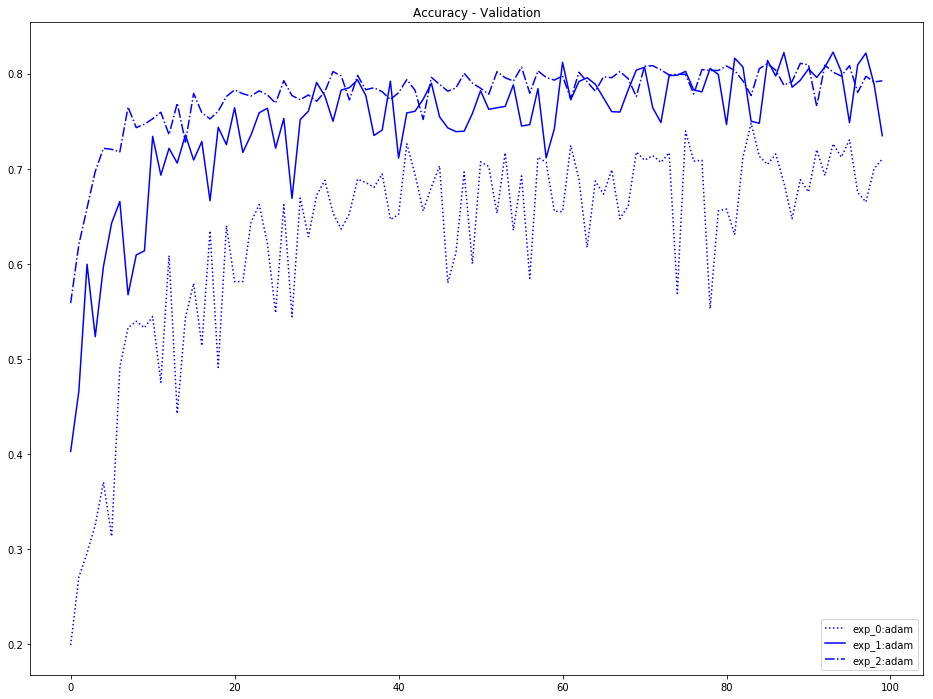

In [11]:
plt.figure(figsize=(16, 12))

# plt.plot(range(len(val_accu["exp_0:sgd"][0])), val_accu["exp_0:sgd"][0], ':',  label="exp_0:sgd", color="r")
# plt.plot(range(len(val_accu["exp_1:sgd"][0])), val_accu["exp_1:sgd"][0], '-',  label="exp_1:sgd", color="r")
# plt.plot(range(len(val_accu["exp_2:sgd"][0])), val_accu["exp_2:sgd"][0], '-.', label="exp_2:sgd", color="r")
# plt.plot(range(len(val_accu["exp_3:sgd"][0])), val_accu["exp_3:sgd"][0], '--', label="exp_3:sgd", color="r")
# plt.plot(range(len(val_accu["exp_4:sgd"][0])), val_accu["exp_4:sgd"][0], '.',  label="exp_4:sgd", color="r")

# plt.plot(range(len(val_accu["exp_0:rmsprop"][0])), val_accu["exp_0:rmsprop"][0], ':',  label="exp_0:rmsprop", color="g")
# plt.plot(range(len(val_accu["exp_1:rmsprop"][0])), val_accu["exp_1:rmsprop"][0], '-',  label="exp_1:rmsprop", color="g")
# plt.plot(range(len(val_accu["exp_2:rmsprop"][0])), val_accu["exp_2:rmsprop"][0], '-.', label="exp_2:rmsprop", color="g")
# plt.plot(range(len(val_accu["exp_3:rmsprop"][0])), val_accu["exp_3:rmsprop"][0], '--', label="exp_3:rmsprop", color="g")
# plt.plot(range(len(val_accu["exp_4:rmsprop"][0])), val_accu["exp_4:rmsprop"][0], '.',  label="exp_4:rmsprop", color="g")

plt.plot(range(len(val_accu["exp_0:adam"][0])), val_accu["exp_0:adam"][0], ':',  label="exp_0:adam", color="b")
plt.plot(range(len(val_accu["exp_1:adam"][0])), val_accu["exp_1:adam"][0], '-',  label="exp_1:adam", color="b")
plt.plot(range(len(val_accu["exp_2:adam"][0])), val_accu["exp_2:adam"][0], '-.', label="exp_2:adam", color="b")
# plt.plot(range(len(val_accu["exp_3:adam"][0])), val_accu["exp_3:adam"][0], '--', label="exp_3:adam", color="b")
# plt.plot(range(len(val_accu["exp_4:adam"][0])), val_accu["exp_4:adam"][0], '.',  label="exp_4:adam", color="b")

# plt.plot(range(len(val_accu["exp_0:adagrad"][0])), val_accu["exp_0:adagrad"][0], ':',  label="exp_0:adagrad", color="y")
# plt.plot(range(len(val_accu["exp_1:adagrad"][0])), val_accu["exp_1:adagrad"][0], '-',  label="exp_1:adagrad", color="y")
# plt.plot(range(len(val_accu["exp_2:adagrad"][0])), val_accu["exp_2:adagrad"][0], '-.', label="exp_2:adagrad", color="y")
# plt.plot(range(len(val_accu["exp_3:adagrad"][0])), val_accu["exp_3:adagrad"][0], '--', label="exp_3:adagrad", color="y")
# plt.plot(range(len(val_accu["exp_4:adagrad"][0])), val_accu["exp_4:adagrad"][0], '.',  label="exp_4:adagrad", color="y")

plt.title("Accuracy - Validation")
plt.legend(loc="lower right")
plt.show()

### Optimizer=Adam, batch_size=64, dropout=0.1有較好的準確率

In [12]:
## '-' solid line style
## '--' dashed line style
## '-.' dash-dot line style
## ':' dotted line style
## '.' point marker
## ',' pixel marker
## 'o' circle marker
## 'v' triangle_down marker
## '^' triangle_up marker
## '<' triangle_left marker
## '>' triangle_right marker
## '1' tri_down marker
## '2' tri_up marker
## '3' tri_left marker
## '4' tri_right marker
## 's' square marker
## 'p' pentagon marker
## '*' star marker
## 'h' hexagon1 marker
## 'H' hexagon2 marker
## '+' plus marker
## 'x' x marker
## 'D' diamond marker
## 'd' thin_diamond marker
## '|' vline marker
## '_' hline marker
## 
## 'b' blue
## 'g' green
## 'r' red
## 'c' cyan
## 'm' magenta
## 'y' yellow
## 'k' black
## 'w' white